In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ensembl_paralogmirna_path = './sd.ensembl_paralogmirna.tsv'
mirgenedb_paralogmirna_path = './sd.mgdb_paralogmirna.tsv'
mirgenedb_ohnomirna_path = './sd.mgdb_ohnomirna.tsv'

df_ensembl_p = pd.read_csv(ensembl_paralogmirna_path, sep='\t')
df_mirgenedb_p = pd.read_csv(mirgenedb_paralogmirna_path, sep='\t')
df_mirgenedb_o = pd.read_csv(mirgenedb_ohnomirna_path, sep='\t')

# remove rows where the third column is not a number
df_ensembl_p = df_ensembl_p[pd.to_numeric(df_ensembl_p.iloc[:, 2], errors='coerce').notnull()]
df_mirgenedb_p = df_mirgenedb_p[pd.to_numeric(df_mirgenedb_p.iloc[:, 2], errors='coerce').notnull()]
df_mirgenedb_o = df_mirgenedb_o[pd.to_numeric(df_mirgenedb_o.iloc[:, 2], errors='coerce').notnull()]

col_names = ['miRNA_1_name', 'miRNA_2_name', 'tarbase_sd_similarity', 'Error_cause']
df_ensembl_p.columns = col_names
df_mirgenedb_p.columns = col_names
df_mirgenedb_o.columns = col_names

In [3]:
putative_intragenic_ohnomirna_path = '../../OhnomiRNAs/dataset/6_ReciprocalBestHits/ohnomirna_paralogmirna.ssdmirna_wgdmirna_ensembl_check.7mer_s5_align_scores.tarbase_flag.strand_check.tarbase_sd.mirdip_top_sd.mirdip_complete_sd.rbh_wgd.tsv'
putative_intragenic_paralogmirna_path = '../../OhnomiRNAs/dataset/6_ReciprocalBestHits/ohnomirna_paralogmirna.ssdmirna_wgdmirna_ensembl_check.7mer_s5_align_scores.tarbase_flag.strand_check.tarbase_sd.mirdip_top_sd.mirdip_complete_sd.rbh_ssd.tsv'

df_putative_intragenic_p = pd.read_csv(putative_intragenic_paralogmirna_path, sep='\t')
df_putative_intragenic_o = pd.read_csv(putative_intragenic_ohnomirna_path, sep='\t')

# remover rows where in one of the two columns "miRNA_1_mirgenedb_flag" or "miRNA_2_mirgenedb_flag" is "mirgenedb_not_confirmed"
df_putative_intragenic_p = df_putative_intragenic_p[
	(df_putative_intragenic_p['miRNA_1_mirgenedb_flag'] != 'mirgenedb_not_confirmed') &
	(df_putative_intragenic_p['miRNA_2_mirgenedb_flag'] != 'mirgenedb_not_confirmed')
]
df_putative_intragenic_o = df_putative_intragenic_o[
	(df_putative_intragenic_o['miRNA_1_mirgenedb_flag'] != 'mirgenedb_not_confirmed') &
	(df_putative_intragenic_o['miRNA_2_mirgenedb_flag'] != 'mirgenedb_not_confirmed')
]

cols_to_keep = ['miRNA_1_name', 'miRNA_2_name', 'tarbase_sd_similarity']
df_putative_intragenic_p = df_putative_intragenic_p[cols_to_keep]
df_putative_intragenic_o = df_putative_intragenic_o[cols_to_keep]

# drop cases where "tarbase_sd_similarity" is NaN
df_putative_intragenic_p = df_putative_intragenic_p.dropna(subset=['tarbase_sd_similarity'])
df_putative_intragenic_o = df_putative_intragenic_o.dropna(subset=['tarbase_sd_similarity'])

In [4]:
# add to df_mirgenedb_o those pairs in df_putative_intragenic_o that are not already in df_mirgenedb_o
df_mirgenedb_o = pd.concat([df_mirgenedb_o, df_putative_intragenic_o[~df_putative_intragenic_o.set_index(['miRNA_1_name', 'miRNA_2_name']).index.isin(df_mirgenedb_o.set_index(['miRNA_1_name', 'miRNA_2_name']).index)]])

In [5]:
unordered_pairs_o = set(tuple(sorted(map(str, row))) for row in df_mirgenedb_o.iloc[:, :2].values)
unordered_intragenic_pairs_o = set(tuple(sorted(map(str, row))) for row in df_putative_intragenic_o.iloc[:, :2].values)
unordered_pairs_o.update(unordered_intragenic_pairs_o)

df_mirgenedb_p = df_mirgenedb_p[~df_mirgenedb_p.iloc[:, :2].apply(lambda x: tuple(sorted(map(str, x))) in unordered_pairs_o, axis=1)]
df_ensembl_p = df_ensembl_p[~df_ensembl_p.iloc[:, :2].apply(lambda x: tuple(sorted(map(str, x))) in unordered_pairs_o, axis=1)]

In [6]:
df_mirgenedb_o

,miRNA_1_name,miRNA_2_name,tarbase_sd_similarity,Error_cause
0,MIRLET7E,MIRLET7C,0.507740,.
1,MIRLET7E,MIRLET7A2,0.518968,.
2,MIRLET7C,MIRLET7A2,0.539730,.
3,MIRLET7A1,MIRLET7A3,1.000000,.
4,MIRLET7A1,MIRLET7F2,0.558642,.
...,...,...,...,...
40,MIR103A1,MIR107,0.971189,NaN
45,MIR103A2,MIR107,0.914454,NaN
53,MIR26B,MIR26A1,0.677007,NaN
62,MIR196A2,MIR196A1,0.883929,NaN


____________________

## Putative intragenic pairs

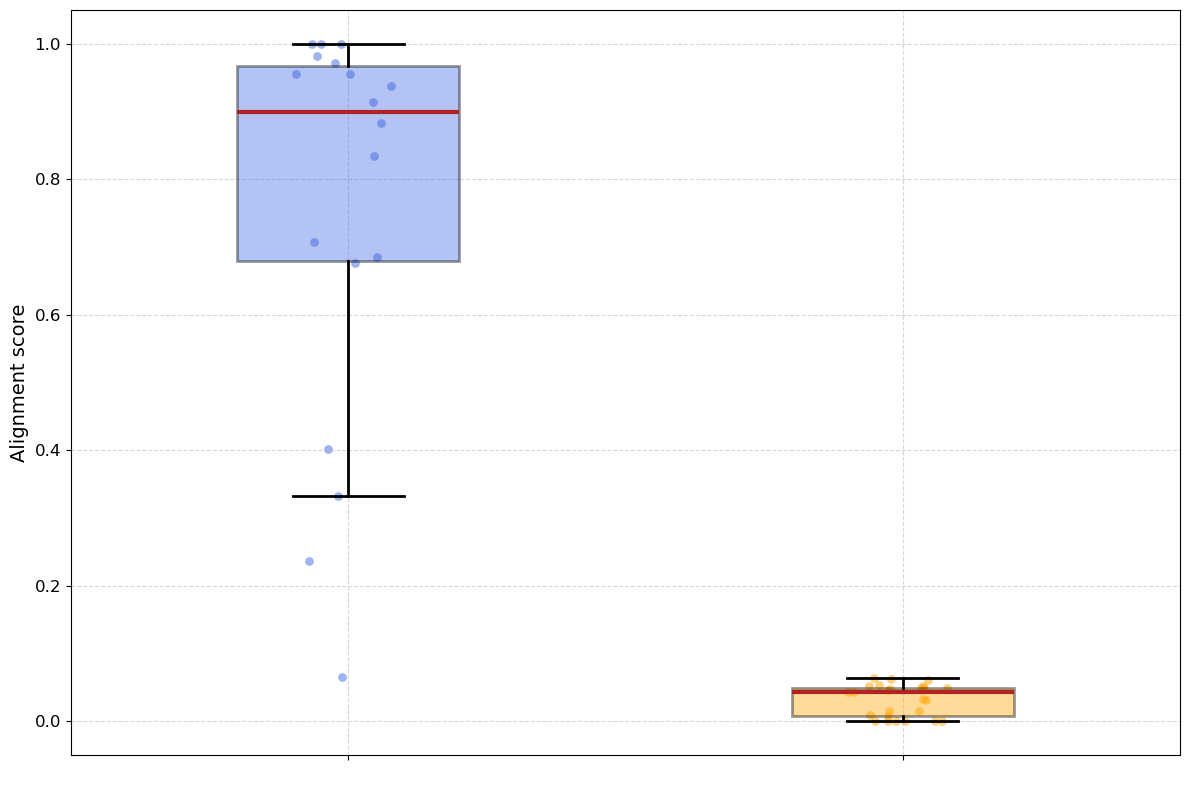

In [7]:
data = [df.iloc[:, 2].dropna().values for df in [df_putative_intragenic_o, df_putative_intragenic_p]]
positions = [0, 1]
colors = ['royalblue', 'orange']

plt.figure(figsize=(12, 8))

box = plt.boxplot(data, 
                  positions=positions, 
                  widths=0.4,
				  #notch=True,
                  patch_artist=True, 
                  showfliers=False)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')
    patch.set_linewidth(2)
    patch.set_alpha(0.4)
    
for element in ['whiskers', 'caps']:
    for line in box[element]:
        line.set_linewidth(2)
        line.set_color('black')
        
for element in ['medians']:
    for line in box[element]:
        line.set_linewidth(3)
        line.set_color('firebrick')

for i, (scores, color) in enumerate(zip(data, colors)):
    jittered_x = np.random.normal(loc=positions[i], scale=0.05, size=len(scores))
    plt.scatter(jittered_x, scores, alpha=0.5, color=color, linewidth=0.2, label=['WGD', 'SSD'][i])

plt.ylabel('Alignment score', fontsize=14)
plt.xticks(positions, [' ', ' '], fontsize=100)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.show()

## MirGeneDB WGD vs. Ensembl SSD

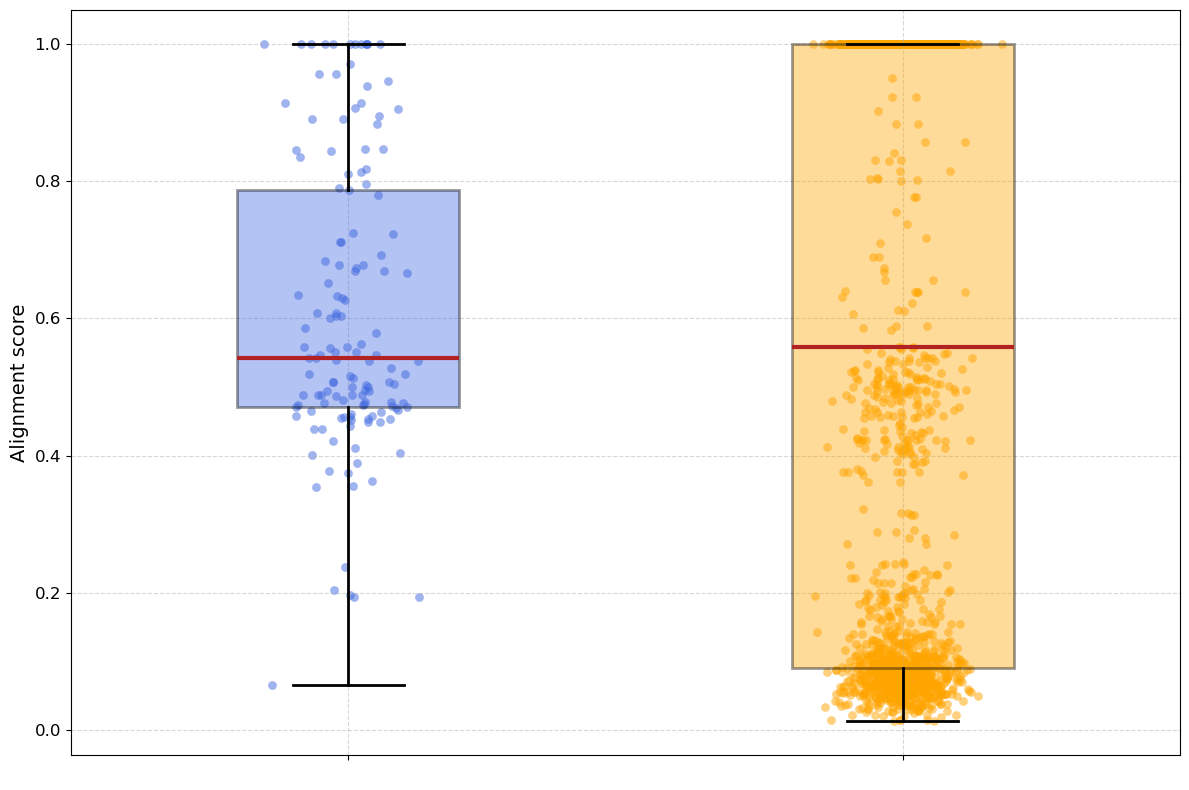

In [8]:
data = [df.iloc[:, 2].dropna().values for df in [df_mirgenedb_o, df_ensembl_p]]
positions = [0, 1]
colors = ['royalblue', 'orange']

plt.figure(figsize=(12, 8))

box = plt.boxplot(data, 
                  positions=positions, 
                  widths=0.4,
				  #notch=True,
                  patch_artist=True, 
                  showfliers=False)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')
    patch.set_linewidth(2)
    patch.set_alpha(0.4)
    
for element in ['whiskers', 'caps']:
    for line in box[element]:
        line.set_linewidth(2)
        line.set_color('black')
        
for element in ['medians']:
    for line in box[element]:
        line.set_linewidth(3)
        line.set_color('firebrick')

for i, (scores, color) in enumerate(zip(data, colors)):
    jittered_x = np.random.normal(loc=positions[i], scale=0.05, size=len(scores))
    plt.scatter(jittered_x, scores, alpha=0.5, color=color, linewidth=0.2, label=['WGD', 'SSD'][i])

plt.ylabel('Alignment score', fontsize=14)
plt.xticks(positions, [' ', ' '], fontsize=100)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.show()

## MirGeneDB WGD vs. MirGeneDB SSD

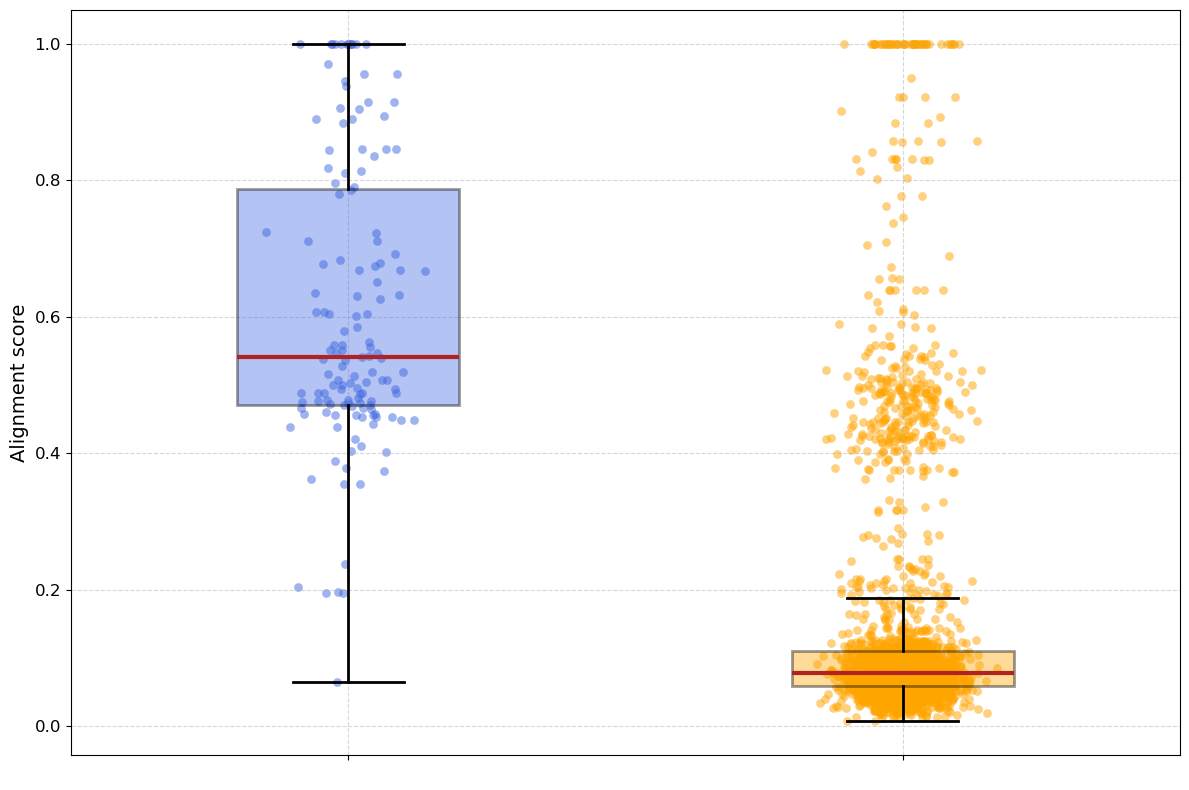

In [9]:
data = [df.iloc[:, 2].dropna().values for df in [df_mirgenedb_o, df_mirgenedb_p]]
positions = [0, 1]
colors = ['royalblue', 'orange']

plt.figure(figsize=(12, 8))

box = plt.boxplot(data, 
                  positions=positions, 
                  widths=0.4,
				  #notch=True,
                  patch_artist=True, 
                  showfliers=False)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')
    patch.set_linewidth(2)
    patch.set_alpha(0.4)
    
for element in ['whiskers', 'caps']:
    for line in box[element]:
        line.set_linewidth(2)
        line.set_color('black')
        
for element in ['medians']:
    for line in box[element]:
        line.set_linewidth(3)
        line.set_color('firebrick')

for i, (scores, color) in enumerate(zip(data, colors)):
    jittered_x = np.random.normal(loc=positions[i], scale=0.05, size=len(scores))
    plt.scatter(jittered_x, scores, alpha=0.5, color=color, linewidth=0.2, label=['WGD', 'SSD'][i])

plt.ylabel('Alignment score', fontsize=14)
plt.xticks(positions, [' ', ' '], fontsize=100)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.show()

______________________

## Number of pairs

In [10]:
print("Number of putative intragenic paralog miRNAs:", len(df_putative_intragenic_p))
print("Number of putative intragenic ohno miRNAs:", len(df_putative_intragenic_o))

Number of putative intragenic paralog miRNAs: 25
Number of putative intragenic ohno miRNAs: 18


In [11]:
print("Number of MirGeneDB paralogmiRNAs:", len(df_mirgenedb_p))
print("Number of MirGeneDB ohnomiRNAs:", len(df_mirgenedb_o))
print("Number of Ensembl paralogmiRNAs:", len(df_ensembl_p))

Number of MirGeneDB paralogmiRNAs: 2512
Number of MirGeneDB ohnomiRNAs: 140
Number of Ensembl paralogmiRNAs: 2064
